# Testing the Simulation Pipeline using RASCIL

The test_simulation_meerkat() already tests the simulation pipeline using OSKAR. So we know this works.

In [1]:
from rascil.processing_components import create_visibility_from_ms

# from karabo.examples.imaging import imaging_cellsize
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulation.line_emission import (
    CircleSkyRegion,
    line_emission_pipeline,
    generate_gaussian_beam_data,
    gaussian_beam_fwhm_for_frequency,
)
from karabo.simulation.interferometer import FilterUnits, InterferometerSimulation
from karabo.imaging.image import Image, ImageMosaicker
from karabo.imaging.imager_base import DirtyImagerConfig
from karabo.simulator_backend import SimulatorBackend

import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from datetime import datetime, timedelta
from pathlib import Path
from karabo.util.file_handler import FileHandler
from typing import List
from ska_sdp_datamodels.image.image_model import Image as RASCILImage
from karabo.util.ska_sdp_datamodels.visibility.vis_io_ms import (  # type: ignore[attr-defined] # noqa: E501
    export_visibility_to_ms,
)
from karabo.imaging.imager_rascil import RascilDirtyImager, RascilDirtyImagerConfig
import xarray as xr

from ska_sdp_func_python.imaging import (
    create_image_from_visibility,
    invert_visibility,
    remove_sumwt,
)
import matplotlib.pyplot as plt

%matplotlib inline

The RASCIL data directory is not available - continuing but any simulations will fail


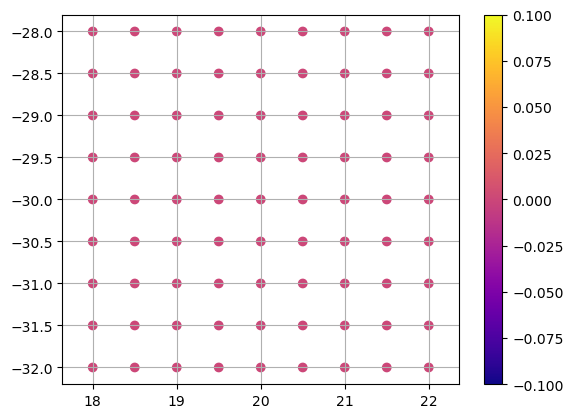

In [2]:
sky = SkyModel.sky_test()
# ONE POINT SOURCE ONLY
# sky = SkyModel()
# sky_data = np.array([[20.0, -30.0, 1]])
# sky.add_point_sources(sky_data)
print(sky)
sky.explore_sky(phase_center=(20, -30), wcs_enabled=False)

## TODO: Here the plot is not plotting the flux correctly -> needs to be resovled in explore_sky()

In [3]:
# Parameter definition
ra_deg = 20
dec_deg = -30
start_time = datetime(2000, 3, 20, 12, 6, 39)
obs_length = timedelta(hours=3, minutes=5, seconds=0, milliseconds=0)
start_freq = 1.5e9
freq_bin = 1.0e7

In [4]:
# Set Imaging parameters
imaging_npixel = 1024
dirty_imager_config = RascilDirtyImagerConfig(
    imaging_npixel=imaging_npixel,
    imaging_cellsize=2 / 180 * np.pi / 1024,
    combine_across_frequencies=False,
)
dirty_imager = RascilDirtyImager(dirty_imager_config)

<xarray.Image>
Dimensions:       (frequency: 1, polarisation: 1, y: 1024, x: 1024)
Coordinates:
  * frequency     (frequency) float64 1.5e+09
  * polarisation  (polarisation) <U1 'I'
  * y             (y) float64 -0.5411 -0.541 -0.541 ... -0.5062 -0.5062 -0.5062
  * x             (x) float64 0.3316 0.3316 0.3317 ... 0.3664 0.3665 0.3665
Data variables:
    pixels        (frequency, polarisation, y, x) float64 1.0 1.0 ... 1.0 1.0
Attributes:
    data_model:           Image
    _polarisation_frame:  stokesI
    _projection:          ('RA---SIN', 'DEC--SIN')
    spectral_type:        FREQ
    clean_beam:           None
    refpixel:             [513. 513.   1.   1.]
    channel_bandwidth:    10000000.0
    ra:                   0.3490658503988659
    dec:                  -0.5235987755982988


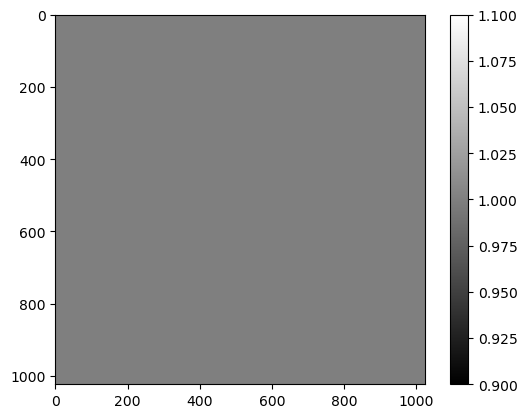

In [32]:
from ska_sdp_datamodels.image import create_image

# Test primary beam

primary_beam = create_image(
    npixel=dirty_imager_config.imaging_npixel,
    cellsize=dirty_imager_config.imaging_cellsize,
    phasecentre=SkyCoord(ra_deg, dec_deg, unit=(u.deg, u.deg), frame="icrs"),
    frequency=start_freq,
    channel_bandwidth=freq_bin,
    nchan=1,
)

fwhm_degrees = 0.25
fwhm_pixels = fwhm_degrees / np.degrees(dirty_imager_config.imaging_cellsize)
beam = generate_gaussian_beam_data(
    fwhm_pixels=fwhm_pixels,
    x_size=dirty_imager_config.imaging_npixel,
    y_size=dirty_imager_config.imaging_npixel,
)
primary_beam["pixels"][0][0] = 1  # beam

print(primary_beam)
plt.imshow(primary_beam["pixels"].data[0, 0, :, :], cmap="gray")
plt.colorbar()

# TODO support full stokes,
# instead of hardcoding index 0 for the polarisation
# primary_beam["pixels"][0][0] = primary_beams[index_freq]

In [33]:
# Simulating visibilities
observation = Observation(
    phase_centre_ra_deg=ra_deg,
    phase_centre_dec_deg=dec_deg,
    start_date_and_time=start_time,
    length=obs_length,
    number_of_time_steps=10,
    start_frequency_hz=start_freq,
    frequency_increment_hz=freq_bin,
    number_of_channels=1,
)
simulation = InterferometerSimulation(
    channel_bandwidth_hz=1.0e7,
    time_average_sec=8,
    ignore_w_components=True,
    # uv_filter_max=10000,
    # uv_filter_min=1,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=False,
    use_dask=False,
    station_type="Isotropic beam",
)

# Load the Meerkat telescope (so we can compare it with the OSKAR simulation)
## TODO: This does not work for RASICL... Or I do not know which telescope is the equivalent in RASCIL
## I will for the moment use SKA-MID
telescope = Telescope.constructor("MID", backend=SimulatorBackend.RASCIL)

visibility = simulation.run_simulation(
    telescope=telescope,
    sky=sky,
    observation=observation,
    backend=SimulatorBackend.RASCIL,
    primary_beam=primary_beam,
    visibility_path="/tmp/karabo-STM-jennifer-QnmZy3ppP6/interferometer-E5jB2QTx5V/RASCIL.MS",
)

Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/interferometer-E5jB2QTx5V/RASCIL.MS to format MS


In [17]:
# # Compute dirty image from visibilities  (imaging_uvmin and uvmax add to code)
# model = create_image_from_visibility(
#     vis_flag,
#     npixel=imaging_npixel,
#     cellsize=2 / 180 * np.pi / 1024,
#     override_cellsize=False,
# )
# dirty, _ = invert_visibility(vis_flag, model, context="2d", imaging_uvmin=0)
#
# dirty.image_acc.export_to_fits(fits_file="./test.fits")
#
# image = Image(path="./test.fits")
# plt.imshow(image.data[0, 0, :, :], cmap="gray")
# plt.colorbar()
# plt.show()

In [34]:
# Imaging
dirty_rascil = dirty_imager.create_dirty_image(visibility)

Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Imager-Dirty-0ViS05fsQn for disk-cache for dirty.fits


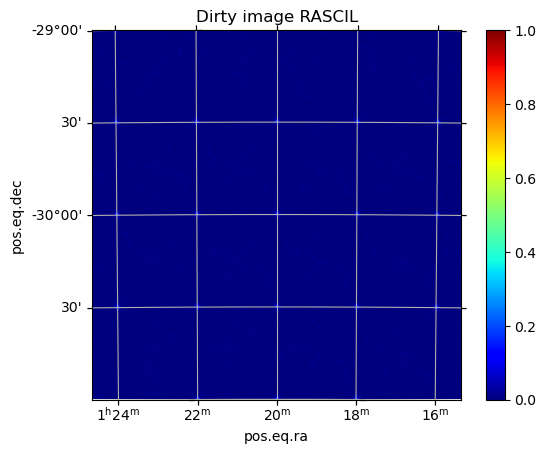

In [35]:
dirty_rascil.plot(title="Dirty image RASCIL", vmin=0, vmax=1.0)

# OSKAR for Comparison

In [36]:
# Load test sky and MeerKAT telescope
# sky = SkyModel.sky_test()
telescope_o = Telescope.constructor("SKA1MID")

# Simulating visibilities
visibility_o = simulation.run_simulation(
    telescope_o,
    sky,
    observation,
    visibility_path="/tmp/karabo-STM-jennifer-QnmZy3ppP6/interferometer-E5jB2QTx5V/OSKAR.MS",
)

# We use the Imager to check the simulation
dirty_imager = RascilDirtyImager(dirty_imager_config)
dirty_oskar = dirty_imager.create_dirty_image(visibility_o)

Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/interferometer-E5jB2QTx5V/OSKAR.MS to format MS
Saved visibility to /tmp/karabo-STM-jennifer-QnmZy3ppP6/interferometer-E5jB2QTx5V/OSKAR.MS
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Imager-Dirty-cDS3oM78KL for disk-cache for dirty.fits


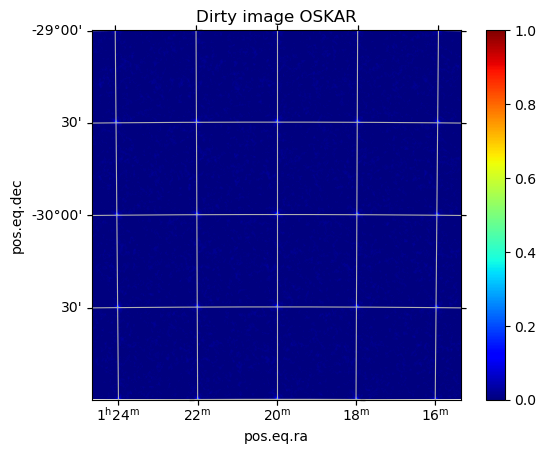

In [37]:
dirty_oskar.plot(title="Dirty image OSKAR", vmin=0, vmax=1.0)

# Compare dirty images

Text(0.5, 1.0, 'Difference between dirty images of OSKAR and RASCIL')

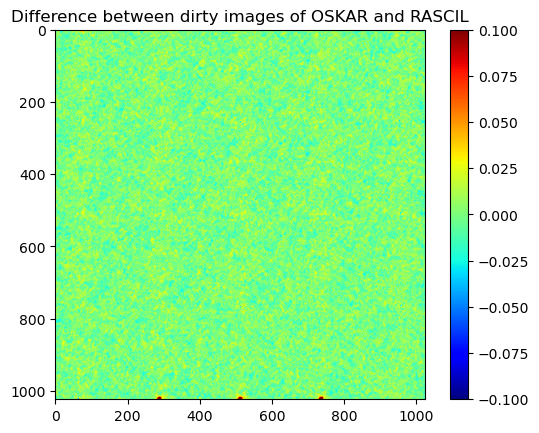

In [22]:
dirty_diff = dirty_oskar.data[0][0] - dirty_rascil.data[0][0]
plt.imshow(dirty_diff, cmap="jet", vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title("Difference between dirty images of OSKAR and RASCIL")

# Compare visibilities

In [15]:
from rascil.processing_components import create_visibility_from_ms

In [16]:
print(visibility.path)
print(visibility_o.path)

/tmp/karabo-STM-jennifer-QnmZy3ppP6/interferometer-E5jB2QTx5V/RASCIL.MS
/tmp/karabo-STM-jennifer-QnmZy3ppP6/interferometer-E5jB2QTx5V/OSKAR.MS


In [17]:
vis = create_visibility_from_ms(str(visibility.path))[0]
vis_o = create_visibility_from_ms(str(visibility_o.path))[0]

In [18]:
print(vis)

<xarray.Visibility>
Dimensions:            (time: 10, baselines: 19503, frequency: 1,
                        polarisation: 1, spatial: 3)
Coordinates:
  * time               (time) float64 4.453e+09 4.453e+09 ... 4.453e+09
  * baselines          (baselines) object MultiIndex
  * antenna1           (baselines) int64 0 0 0 0 0 0 ... 194 194 194 195 195 196
  * antenna2           (baselines) int64 0 1 2 3 4 5 ... 194 195 196 195 196 196
  * frequency          (frequency) float64 1.5e+09
  * polarisation       (polarisation) <U1 'I'
  * spatial            (spatial) <U1 'u' 'v' 'w'
Data variables:
    integration_time   (time) float64 1.11e+03 1.11e+03 ... 1.11e+03 1.11e+03
    datetime           (time) datetime64[ns] 2000-01-01T15:39:28.908284116 .....
    vis                (time, baselines, frequency, polarisation) complex128 ...
    weight             (time, baselines, frequency, polarisation) float64 1.0...
    flags              (time, baselines, frequency, polarisation) int64 0 ... 

In [19]:
print(vis_o)

<xarray.Visibility>
Dimensions:            (time: 10, baselines: 19503, frequency: 1,
                        polarisation: 4, spatial: 3)
Coordinates:
  * time               (time) float64 4.46e+09 4.46e+09 ... 4.46e+09 4.46e+09
  * baselines          (baselines) object MultiIndex
  * antenna1           (baselines) int64 0 0 0 0 0 0 ... 194 194 194 195 195 196
  * antenna2           (baselines) int64 0 1 2 3 4 5 ... 194 195 196 195 196 196
  * frequency          (frequency) float64 1.5e+09
  * polarisation       (polarisation) <U2 'XX' 'XY' 'YX' 'YY'
  * spatial            (spatial) <U1 'u' 'v' 'w'
Data variables:
    integration_time   (time) float64 1.11e+03 1.11e+03 ... 1.11e+03 1.11e+03
    datetime           (time) datetime64[ns] 2000-03-20T12:06:39.000000232 .....
    vis                (time, baselines, frequency, polarisation) complex128 ...
    weight             (time, baselines, frequency, polarisation) float64 0.0...
    flags              (time, baselines, frequency, pola

In [20]:
# print(vis["vis"])
print(np.shape(vis["uvw"].data))
print(np.shape(vis["vis"].data))

(10, 19503, 3)
(10, 19503, 1, 1)


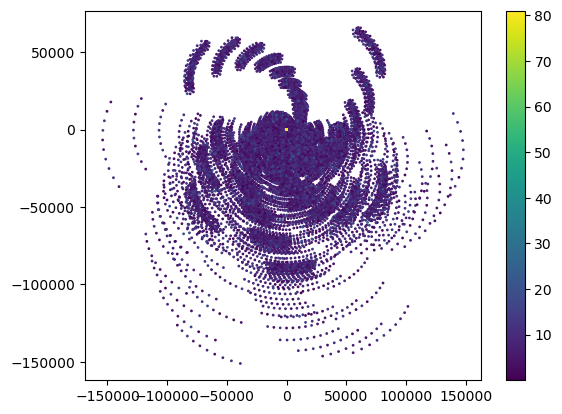

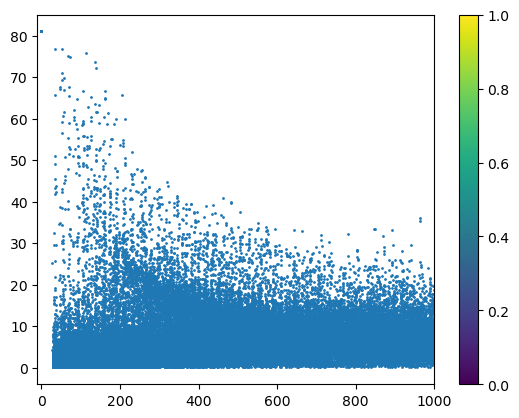

[81. 81. 81. ... 81. 81. 81.]


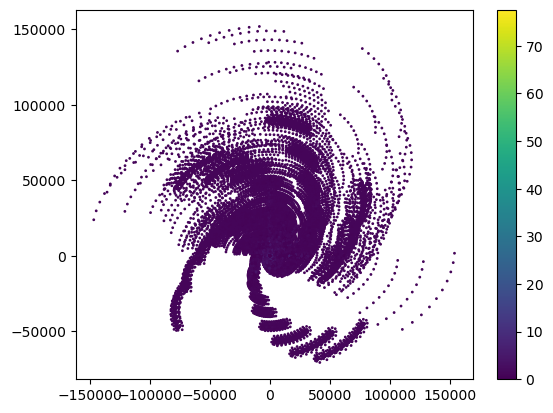

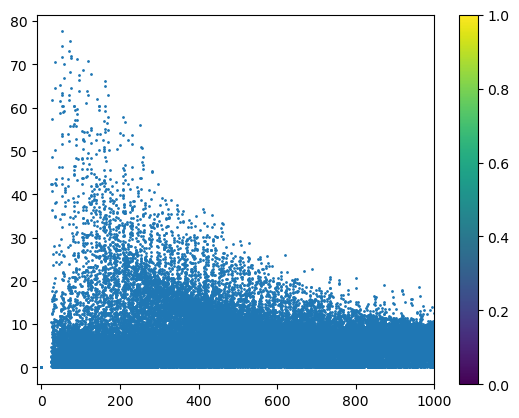

[]


In [21]:
vis_both = [vis, vis_o]
for v in vis_both:
    visi = v["vis"].data
    uvw = v["uvw"].data

    plt.figure()
    plt.scatter(uvw[:, :, 0], uvw[:, :, 1], c=abs(visi[:, :, 0, 0]), s=1)
    # plt.xlim(-100, 100)
    # plt.ylim(-100, 100)
    plt.colorbar()
    plt.show()

    plt.figure()
    plt.scatter(
        np.sqrt(uvw[:, :, 0] ** 2 + uvw[:, :, 1] ** 2), abs(visi[:, :, 0, 0]), s=1
    )
    plt.xlim(-10, 1000)
    plt.colorbar()
    plt.show()

    uv = np.sqrt(uvw[:, :, 0] ** 2 + uvw[:, :, 1] ** 2)

    uv_0 = np.where(uv == 0)
    vis_0 = abs(visi[uv_0])
    nonzero_in = np.nonzero(vis_0)
    # print(abs(visi[uv_0]))
    print(vis_0[nonzero_in])
    # print(uvw[uv_0, :, 0])